### Reconstruct Positions with UMAP

In [1]:
import anndata
import umap
import sys
import scanpy
import numpy as np
import sklearn
sys.path.append("../functions/")
import distances
import utils
from matplotlib import pyplot as plt

In [3]:
# Set parameters and load the data
tissue = 'kidney' # Slide-seq tissue sample
rpb = 140 # Median reads per bead
satellites = 10**5 # Satellites per cm2
sigma = 50 # Sigma for the Gaussian modelling difussion around a satellite in um

adata = anndata.read_h5ad('../data/adata/{}_{}rpb_satellites={}_sigma={}.h5ad'.format(tissue, rpb, satellites, sigma))
n = np.sqrt(adata.shape[0])

In [4]:
# Normalize the data and run UMAP
adata.X = sklearn.preprocessing.normalize(adata.X, norm='l1')
mapper = umap.UMAP(n_neighbors=60, metric='euclidean', random_state=0, n_epochs=5000, min_dist=0.75, unique=True, verbose=True)
coords = mapper.fit_transform(adata.X)

UMAP(min_dist=0.75, n_epochs=5000, n_neighbors=60, random_state=0, unique=True,
     verbose=True)


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Unique=True -> Number of data points reduced from  99856  to  99809
Most common duplicate is 63076  with a count of  3
Construct fuzzy simplicial set
Sat Apr  2 19:22:06 2022 Finding Nearest Neighbors
Sat Apr  2 19:22:06 2022 Building RP forest with 21 trees
Sat Apr  2 19:25:13 2022 metric NN descent for 17 iterations
	 0  /  17
	 1  /  17
Sat Apr  2 19:29:52 2022 Finished Nearest Neighbor Search
Sat Apr  2 19:29:56 2022 Construct embedding
	completed  0  /  5000 epochs
	completed  500  /  5000 epochs
	completed  1000  /  5000 epochs
	completed  1500  /  5000 epochs
	completed  2000  /  5000 epochs
	completed  2500  /  5000 epochs
	completed  3000  /  5000 epochs
	completed  3500  /  5000 epochs
	completed  4000  /  5000 epochs
	completed  4500  /  5000 epochs
Sat Apr  2 20:21:03 2022 Finished embedding


In [5]:
# Align the UMAP with the ground-truth
ground_truth = np.array([adata.obs.x, adata.obs.y]).T
dist_gt, aligned_coords, transf = distances.align(coords, ground_truth, rel_scale=1)
dist_gt = dist_gt*n*10 # Scale distance to ground truth to um

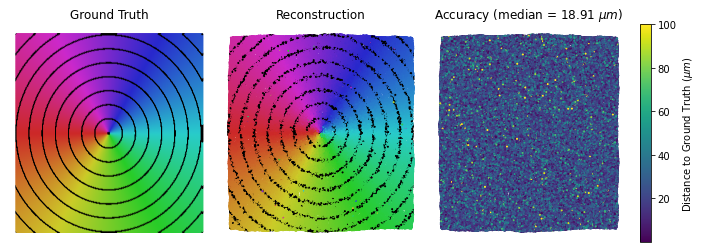

In [8]:
# Compare the reconstruction to the ground truth
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,16)
plt.subplot(gs[:,:5])
plt.title('Ground Truth')
plt.scatter(adata.obs.x, adata.obs.y, c=adata.obs.spatial_color, s=1)
plt.axis('off')

plt.subplot(gs[:,5:10])
plt.title('Reconstruction')
indices = np.arange(adata.shape[0])
np.random.shuffle(indices)
plt.scatter(aligned_coords[indices][:,0], aligned_coords[indices][:,1], c=adata[indices].obs.spatial_color, s=1)
plt.axis('off')

plt.subplot(gs[:,10:])
plt.title('Accuracy (median = {:.2f} $\mu m$)'.format(np.median(dist_gt)))
plt.scatter(aligned_coords[indices][:,0], aligned_coords[indices][:,1], c=dist_gt, s=1, vmax=100)
plt.colorbar(label='Distance to Ground Truth ($\mu m$)', orientation = 'vertical')
plt.axis('off')

plt.show()

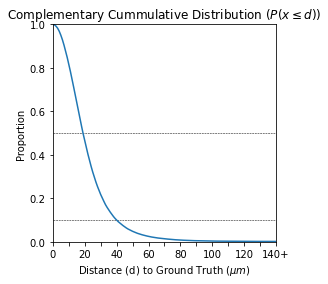

In [9]:
# Plot the complementary cummulative distribution
max_dist = 140
bins = np.arange(0, max_dist, 1)
bins = np.append(bins, max(max(dist_gt), max_dist))
hist = plt.hist(dist_gt, bins=bins, density=True, cumulative=True)
vals = np.insert(hist[0],0,0)
plt.close()

fig = plt.figure(figsize=(4,4))
plt.title('Complementary Cummulative Distribution ($P(x \leq d)$)')
plt.plot(bins, 1 - vals)
plt.ylabel('Proportion')
plt.xlabel('Distance (d) to Ground Truth ($\mu m$)')

plt.xlim([0,max_dist])
plt.ylim([0,1])
xticks = np.arange(0,max_dist+1,10)
xlabels = ['{}+'.format(t) if t == max(xticks) else '{}'.format(t) if t % 20 == 0 else '' for t in xticks]
plt.xticks(ticks=xticks, labels=xlabels)

plt.axhline(0.1, c='k', linestyle='dashed', linewidth=0.5, zorder=0)
plt.axhline(0.5, c='k', linestyle='dashed', linewidth=0.5, zorder=0)
plt.show()